### James Butcher - 5-18-25

A basic test setup for LangGraph using Python and Ollama running locally.

From tutorial video: https://www.youtube.com/watch?v=1w5cCXlh7JQ&t=1178s

## Basic imports

In [1]:
import os
from datetime import datetime

## LLM

In [2]:
from langchain_ollama import ChatOllama

model_path = os.path.expanduser(
    "~/.cache/lm-studio/models/lmstudio-community/"
    "Meta-Llama-3-8B-Instruct-GGUF/Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
)

""" API Docs: 
https://python.langchain.com/api_reference/ollama/chat_models/langchain_ollama.chat_models.ChatOllama.html
"""
llm = ChatOllama(
    model="llama3.2",
    model_path=model_path,
    chat_format="chatml", # Works with most models
    temperature=1.0,  # Controlds the randomness/creativity [0.0 - 2.0]
    num_predict=64,  # Max number of tokens
    #n_ctx=2048, # Context length - default: 2048 (others are 512, 1024, 4096)
    #n_threads=4, # Number of threads to use for inference (default is 4)
    #num_predict=128  # Maximum number of tokens to predict when generating text. (Default: 128, -1 = infinite generation, -2 = fill context)
)

## Types and Fields imports

In [3]:
from typing import Annotated, Literal
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

## LangGraph Imports

In [4]:
from langgraph.graph import StateGraph, START, END  # For building the graph
from langgraph.graph.message import add_messages    # For defining states

## Define Special Models

For special LLM nodes that do tasks like classification, tool calling, etc.

In [5]:
class MessageClassifier(BaseModel):
    message_type: Literal["emotional", "logical"] = Field(
        ..., 
        description="Classify whether the message requires an" \
        "emotional or a logical response."
    )

## Define States

Define the structure of the "States" to be used by the graph
The below definition forces states to be of this form:
```
{ 
    "messages": [ <messages list> ]
    "message_type": str ("logical" or "therapist")
}
```

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    message_type: str | None
    workspace: str | None
    thoughts: str | None

## Define Nodes (Actions)

Define a node by creating a function that takes a state and returns a modified state.

In [7]:
def chatbot(state: State):
    # Take all the messages from the previous state and pass it to the LLM.
    # Then set the new set of messages to the response.
    return {"messages": [llm.invoke(state["messages"])]}

In [8]:
def classify_message(state: State):
    last_message = state["messages"][-1]

    # Create a version of the llm that follows the structured output defined by MessageClassifier.
    classifier_llm = llm.with_structured_output(MessageClassifier)

    result = classifier_llm.invoke([
        # System messages are instructions for the LLM
        {
            "role": "system", 
            "content": """
                Classify the user message as either:
                    'emotional': if it asks for emotional support or deals
                    with feelings, emotions, etc.
                    'logical': if it asks for facts, information, logical
                    analysis, or practical solutions.
            """
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ])

    # Returns a State object with modified 'message_type' field defined
    # above in State class. This message type is then passed to the
    # router that makes a decision based on that message type.
    return {"message_type": result.message_type} 

In [9]:
def router(state: State):
    # Obtain the message type of the given state. Use 'logical' as a
    # fallback in case the message type is missing or invalid.
    message_type = state.get("message_type", "logical")

    if message_type == 'emotional':
        print("<<< therapist >>>")
        return {"next": "therapist"}
    
    print("<<< logical >>>")
    return {"next": "logical"}

In [10]:
def make_change(state: State):
    last_message = state["messages"][-1]

    # Give the user's last message to the LLM with these instructions
    messages = [
        {
            "role": "system",
            "content": """
                You are an artist with words. Change, add, or remove one or more
                of the words in user's sentence to make something truly beautiful.
                Return only the resulting sentence after the change.
            """
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)

    # Return the agent's reply
    return {"messages": [
        {
            "role": "assistant",
            "content": reply.content
        }
    ]}

In [11]:
def reflect(state: State):
    last_message = state["messages"][-1]

    # Give the user's last message to the LLM with these instructions
    messages = [
        {
            "role": "system",
            "content": """
                You are a purely logical assistant. Focus only on facts and information.
                Provide clear, concise answers based on logic and evidence.
                Do not address emotions or provide emotional support.
                Be direct and straightforward in your responses.
                Keep the message to 50 tokens or less.
            """
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)

    # Return the agent's reply
    return {"messages": [
        {
            "role": "assistant",
            "content": reply.content
        }
    ]}

## Build the Graph

In [12]:
graph_builder = StateGraph(State)

#### Add all the nodes defined above

In [13]:
graph_builder.add_node("classifier", classify_message)
graph_builder.add_node("router", router)
graph_builder.add_node("therapist", therapist_agent)
graph_builder.add_node("invariant", logical_agent)

#### Connect all the nodes
- All graphs require a start and end node.

In [14]:
graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router")
graph_builder.add_conditional_edges(
    "router",
    lambda state: state.get("next"), {
        "therapist": "therapist",
        "logical": "invariant" 
    }
)
graph_builder.add_edge("therapist", END)
graph_builder.add_edge("invariant", END)

#### Compile the graph

In [15]:
graph = graph_builder.compile()

#### Display the graph

Only works in Jupyter Notebook

In [16]:
from IPython.display import Image, display

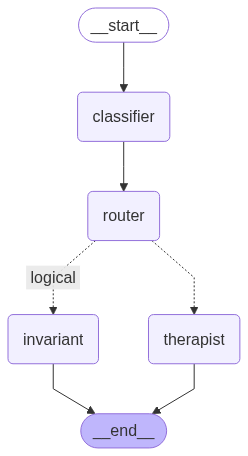

In [17]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This reqires some additional dependencies and is optional
    pass

# Usage

#### Define functions for interacting with graph

In [18]:
def create_chat_log():
    chat_filename = "output_" + datetime.now().strftime("%Y-%m-%d_(%H%M)") + ".txt"
    chat_filepath = "ChatLogs/" + chat_filename
    with open(chat_filepath, "w") as out:
        out.write(str(datetime.now()) + "\n" + '-'*50 + "\n\n")
    return chat_filepath

In [19]:
def get_initial_state():
    return { 
        "messages": [],
        "message_type": None
    }

In [20]:
def write_to_log(path: str, message: str):
    with open(path, "a") as out:
        out.write(message + "\n\n")

In [21]:
def run_graph(state: State, chat_log_path: str):

    user_input = input("Message: ")
    
    write_to_log(chat_log_path, f"User: {user_input}")

    # Append user input to the messages stored in state
    state["messages"] = state.get("messages", []) + [
        {"role": "user", "content": user_input}
    ]

    # Invoke the LLM on the state containing the new user input
    state = graph.invoke(state)

    # Display the LLM's response and write to log
    if state.get("messages") and len(state["messages"]) > 0:
        last_message = state["messages"][-1]
        print(f"Assistant: {last_message.content}")
        write_to_log(chat_log_path, "Assistant: " + last_message.content + "\n\n" + '-'*50)


#### Run the graph

In [22]:
log = create_chat_log()

In [23]:
state = get_initial_state()

In [24]:
run_graph(state, log)

Message:  How many seconds are in one hour?


<<< logical >>>
Assistant: There are 3600 seconds in one hour, as there are 60 minutes in an hour and 60 seconds in a minute.


In [25]:
# def run_graph():

#     # Set initial state
#     state = { 
#         "messages": [],
#         "message_type": None
#     }

#     # Create an output log file
#     from datetime import datetime
#     output_filename = "output_" + datetime.now().strftime("%Y-%m-%d_%H:%M") + ".txt"
#     with open(output_filename, "w") as out:
#             out.write(str(datetime.now()) + "\n" + '-'*50)

#     while True:

#         # Get user input
#         user_input = input("Message: ")
#         if user_input.lower() in ["q", "quit", "bye", "exit"]:
#             print("Bye")
#             break

#         # Write the user input to the log
#         with open(output_filename, "a") as out:
#             out.write(f"User: {user_input}\n\n")

#         # Append user input to the messages stored in stateA
#         state["messages"] = state.get("messages", []) + [
#             {"role": "user", "content": user_input}
#         ]

#         # Invoke the LLM on the state containing the new user input
#         state = graph.invoke(state)

#         # Display the LLM's response and write to log
#         if state.get("messages") and len(state["messages"]) > 0:
#             last_message = state["messages"][-1]
#             print(f"Assistant: {last_message.content}")
#             with open(output_filename, "a") as out:
#                 out.write(f"Assistant: {last_message.content}\n\n" + '-'*50 + "\n")

In [26]:
run_graph()

TypeError: run_graph() missing 2 required positional arguments: 'state' and 'chat_log_path'